In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


In [2]:
const STATIC_LECTURE = true;

In [3]:
function draw(plt)
    if STATIC_LECTURE
        filename = Base.Filesystem.tempname() * ".png"
        savefig(filename)
        return display("image/png", read(filename))
    else
        return plt
    end
end

draw (generic function with 1 method)

In [4]:
using Plots; default(label=nothing, l=2, size=(800,500));
if !STATIC_LECTURE
    using Interact;
end

(**Follow along: <https://tinyurl.com/gtcse6643lec3>**)

### Warmups

1. What is the induced 2-norm of a unitary matrix?

2. Can you prove the fact below from last lecture?

If $D\in\mathbb{C}^{m \times m}$ is diagonal,

$$
\|D\|_p = \max_{1 \leq i \leq m} |d_i|, \quad 1\leq p \leq \infty.
$$

Start with the definition of the matrix $p$-norm:

$$
\|D\|_p = \sup_{\|x\|_p = 1} \| D x \|_p = \dots
$$

In [5]:
using LinearAlgebra

m = 5
d = randn(m)

5-element Vector{Float64}:
  2.8592902774245985
  1.426194262131419
  0.4548159611001695
 -1.2608167894483713
  0.5071055695363266

In [6]:
D = diagm(d)
opnorm(D,1) # in Julia `opnorm` is the induced norm

2.8592902774245985

In [7]:
opnorm(D,2)

2.8592902774245985

In [8]:
opnorm(D,Inf)

2.8592902774245985

# Norms (Part II) and the SVD

1. **Cauchy-Schwarz / Hölder Inequalities and Duality**
2. **Submultiplicativity**
3. **Frobenius Norm and Invariance under Unitary Multiplication**
4. **SVD: Geometric Observation**
5. **Reduced SVD, Full SVD, and Formal Definition**

## Review: Induced Matrix Norm

Given norms $\|\cdot\|_{(m)}$ and $\|\cdot\|_{(n)}$ on $\mathbb{C}^m$ and $\mathbb{C}^n$,

$$
\| A \|_{(m,n)} = \sup_{\|x\|_{(n)} = 1} \| A x \|_{(m)} = \sup_{x \neq 0} \frac{\| A x \|_{(m)}}{\| x \|_{(n)}}.
$$

If $(m) = (n) = p$, we say $\| \cdot \|_p$.

Two cases where $\| A \|_{p}$ can be computed directly:

1.
$$
\| A \|_1 = \max_{1\leq j \leq n} \| a_j \|_1, \quad a_j\text{ column of }A.
$$

2.
$$
\| A \|_\infty = \| A^* \|_1 = \max_{1 \leq i \leq m} \| a_i^* \|_1 \quad a_i^*\text{ row of }A.
$$

In [9]:
m = 3; n = 2
A = randn(m,n)

3×2 Matrix{Float64}:
 -1.5076    1.34028
 -1.16159  -0.394097
 -0.67967  -1.84294

In [10]:
norm.([A[:,1],A[:,2]],1)

2-element Vector{Float64}:
 3.3488665115659657
 3.5773252430266425

In [11]:
opnorm(A,1)

3.5773252430266425

For general $1 < p < \infty$ (most importantly $p=2$) and general $A$, $\|A\|_p$ _cannot be computed exactly in finite steps!_

We still use $\|A\|_p$ (particularly $p\in\{1,2,\infty\}$) all the time because it can be approximated very quickly.

## Cauchy-Schwarz and Hölder Inequalities

If $\frac{1}{p} + \frac{1}{q} = 1$, $1 \leq p, q \leq \infty$, the **Hölder inequality** states that

$$
| x^* y | \leq \| x \|_p \| y \|_q, \quad \forall x, y \in\mathbb{C}^m.
$$

In [12]:
m = 4; p = 1. + rand(); q = 1 / (1 - 1 /p);
[p q]

1×2 Matrix{Float64}:
 1.41499  3.40967

In [13]:
x = randn(m); y = randn(m);
[x y]

4×2 Matrix{Float64}:
 -0.353934  -0.789583
 -0.807389   0.576983
  0.060029  -0.862132
 -1.38928    0.287545

In [14]:
abs(x'*y)

0.6376223131676308

In [15]:
[norm(x,p) norm(y,q) norm(x,p)*norm(y,q)]

1×3 Matrix{Float64}:
 1.9538  1.05941  2.06988

### Proof, case $p=1$, $q=\infty$

$$
\big|\sum_{i=1}^m u_i v_i \big| \leq \sum_{i=1}^m |u_i v_i| \leq \max_{1\leq i \leq m} |v_i| \sum_{i=1}^m |u_i| = \|u\|_1 \|v\|_\infty$$

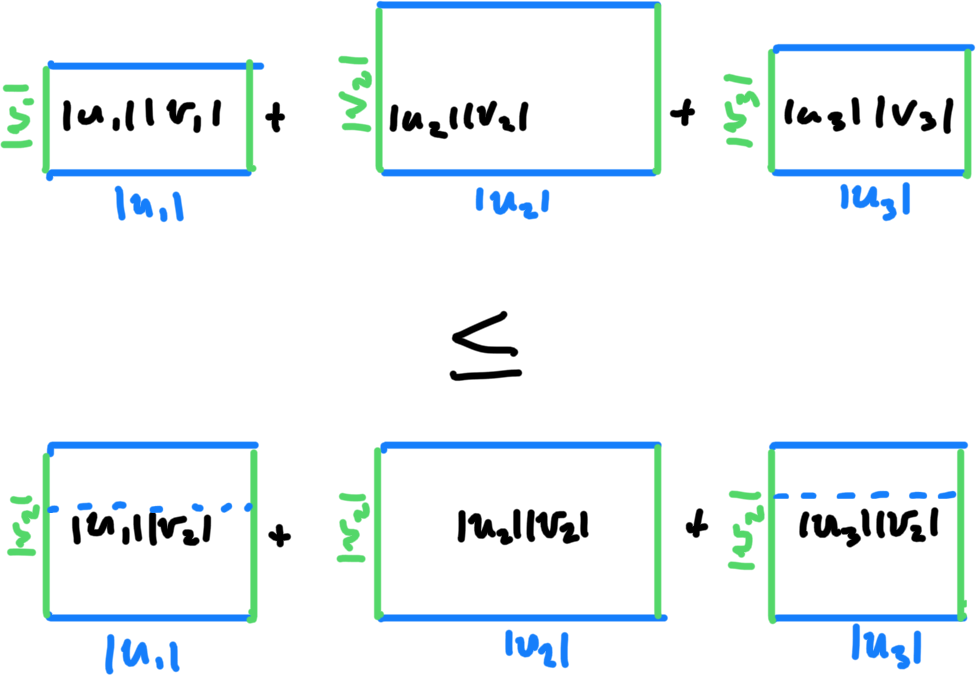

## Proof, case $p = q = 2$ (Cauchy-Schwarz)

Recall $\cos \alpha_{xy} = \frac{x^*y}{\|x\|_2\|y\|_2}$:

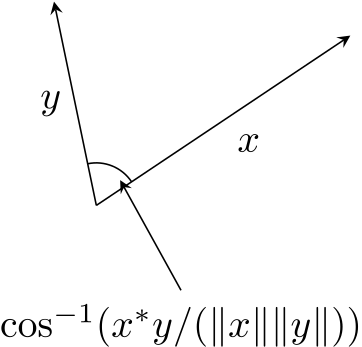

$$
|x^*y| = |\cos \alpha_{xy}| \|x\|_2 \|y\|_2 \leq \|x\|_2 \|y\|_2.
$$

### Proof, general case

$$|x^* y| \leq \|x\|_p \|y\|_q, \quad \frac{1}{p} + \frac{1}{q} = 1, \quad x,y\in\mathbb{C}^{m}.$$

Challenge exercise (Hölder's inequality = [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality) + [Young's Inequality](https://en.wikipedia.org/wiki/Young%27s_inequality_for_products))

### T&B, Example 3.6: The 2-norm of an Outer Product

**Claim:** Given $A = uv^*$, $u\in\mathbb{C}^m$, $v \in \mathbb{C}^n$, $\|A\|_2 = \|u\|_2 \|v\|_2$.

_Proof._ First show $\|A\|_2 \leq \|u\|_2 \|v\|_2$.

Expand the definition ...
$$
\|A\|_2 = \sup_{\|x\|_2 = 1} \|Ax\|_2 = \sup_{\|x\|_2 = 1} \|u v^* x\|_2
\dots$$

Using absolute homogeneous scaling of norms ...
$$=\sup_{\|x\|_2 = 1} |v^*x| \|u\|_2 = \|u\|_2 \sup_{\|x\|_2 = 1} |v^* x|\dots$$

... and apply Cauchy-Schwarz
$$
\leq \|u\|_2 \sup_{\|x\|_2 =1} \|v\|_2 \|x\|_2 =\|u\|_2 \|v\|_2.
$$

To prove equality:

$$\|A v\|_2 = \|u v^*v\|_2 = \|v\|_2^2 \|u\|_2 \Rightarrow \frac{\|Av\|_2}{\|v\|_2} = \|v\|_2 \|u\|_2.$$ 

### Dual norms

If $\frac{1}{p} + \frac{1}{q} = 1$,

$$\|x\|_p = \frac{\|x\|_p \|y\|_q}{\|y\|_q} \geq \frac{|x^* y|}{\|y\|_q} \Rightarrow \|x\|_p \geq \sup_{y \neq 0} \frac{|x^*y|}{\|y\|_q}.$$

This is in fact an equality. $\|\cdot \|_p$ and $\|\cdot \|_q$ are _dual norms:_

$$\|x\|_p = \sup_{\|y\|_q = 1} |x^*y|, \quad \|y\|_q = \sup_{\|x\|_p = 1} |y^*x|.$$
(Compare HW1, problem 7)

### Consequence: $\|A\|_p = \|A^*\|_q$
$$\|A\|_p = \sup_{\|x\|_p = 1} \|Ax\|_p = \sup_{\|x\|_p = 1, \|y\|_q = 1} |(Ax)^* y| \dots$$

$$ = \sup_{\|y\|_q = 1, \|x\|_p = 1} |x^*(A^* y)| = \sup_{\|y\|_q = 1} \| A^* y\|_q = \|A^*\|_q.$$

## Induced matrix norms are _submultiplicative_

For any induced norm and $x\neq 0$,

$$\big\| A \frac{x}{\|x\|}\big\| \leq \sup_{y\neq 0} \big\| A \frac{y}{\|y\|}\big\| =
\sup_{y \neq 0} \frac{\|Ay\|}{\|y\|} = \|A\|.$$

$$\Rightarrow \|Ax\| \leq \|A\|\|x\|, \quad \forall x.$$

Now consider the induced norm of the product matrix $AB$:

$$\|(AB)x\| = \|A(Bx)\| \leq \|A\|\|Bx\| \leq \|A\|\|B\|\|x\|, \quad \forall x.$$

$$\Rightarrow \frac{\|(AB)x\|}{\|x\|} \leq \|A\|\|B\|, \quad \forall x.$$

$$\Rightarrow \|AB\| = \sup_{x\neq 0} \frac{\|(AB)x\|}{\|x\|} \leq \|A\|\|B\|.$$

We say induced matrix norms are _submultiplicative_.

In [16]:
m = 10; k = 8; n = 5;

A = randn(10,8); B = randn(8,5);

[opnorm(A*B,2) opnorm(A,2)*opnorm(B,2)]

1×2 Matrix{Float64}:
 11.871  24.2988

## Frobenius norm

Remember, $\mathbb{C}^{m \times n}$ is a _vector space:_ not all norms have to be induced norms.

A very important norm that is not an induced norm is the **Frobenius norm** $\|\cdot \|_F$:

$$
\|A\|_F = \left(\sum_{i=1}^m\sum_{j=1}^n |a_{ij}|^2\right)^{1/2}.
$$

(Think of it as the 2-norm of $A$ unrolled as a vector.)

In [17]:
A = rand(4,3)

4×3 Matrix{Float64}:
 0.697616  0.407475  0.61081
 0.516804  0.891743  0.357345
 0.836497  0.213546  0.407115
 0.291131  0.491414  0.432104

In [18]:
norm(A,2) # Frobenius norm (treat A as a vector)

1.9078289365412957

In [19]:
norm(reshape(A,(12,)),2)

1.9078289365412957

In [20]:
opnorm(A,2) # Induced 2-norm

1.8062205225687522

### Frobenius norm is the Frobenius norm of the adjoint

$$
\|A\|_F = \left(\sum_{i=1}^m\sum_{j=1}^n |a_{ij}|^2\right)^{1/2}
=
\left(\sum_{j=1}^n\sum_{i=1}^m |\bar a_{ij}|^2\right)^{1/2}
=
\|A^*\|_F
$$

In [21]:
[norm(A, 2) norm(A', 2)]

1×2 Matrix{Float64}:
 1.90783  1.90783

### Frobenius norm = 2-norm of column 2-norms = 2-norm of row 2-norms

$$
\|A\|_F = \left(\sum_{j=1}^n \|a_j\|_2^2\right)^{1/2} = \left(\sum_{i=1}^m \|a_i^*\|_2^2\right)^{1/2}.
$$

In [22]:
[norm(A,2) norm([norm.(A[:,j],2) for j = 1:3],2) norm([norm.(A[i,:]) for i = 1:4],2)]

1×3 Matrix{Float64}:
 1.90783  1.90783  1.90783

### Frobenius norm is related to trace

Recall that the _trace_ of a square matrix (sum of the diagonal) is also the sum of the eigenvalues of the matrix (repeated with algebraic multiplicity):

$$
\mathrm{tr}(A) = \sum_{i=1}^m a_{ii} = \sum_{\lambda \in \rho(A)} \lambda_i \cdot \underbrace{\mu_i}_{\text{multiplicity of }\lambda_i}
$$

The Frobenius norm is

$$
\|A\|_F = \sqrt{\mathrm{tr}(A^* A)} = \sqrt{\mathrm{tr}(AA^*)}.
$$

In [23]:
[norm(A,2) sqrt(tr(A' * A)) sqrt(tr(A * A'))]

1×3 Matrix{Float64}:
 1.90783  1.90783  1.90783

(This fact is very useful for proving things about $\|\cdot\|_F$ without
expanding the summation.)

### The Frobenius norm is also submultiplicative

Let $A\in \mathbb{C}^{m \times k}, B \in \mathbb{C}^{k \times n}$, and let $a_i^*$ be the $i$th row of $A$ and let $b_j$ be the $j$th column of $B$:

$$
\|AB\|_F^2 = \sum_{i=1}^m \sum_{j=1}^n |a_i^* b_j|^2
$$

(apply Cauchy-Schwarz)

$$\leq \sum_{i=1}^m \sum_{j=1}^n \|a_i^*\|_2^2 \| b_j \|_2^2 = \left(\sum_{i=1}^m \|a_i^*\|_2^2\right)
\left(\sum_{j=1}^n \|b_j\|_2^2\right) = \|A\|_F^2 \|B\|_F^2$$

### Exercise: Unitary Invariance of Matrix 2-norm and Frobenius Norm

**T&B Theorem 3.1:** For any $A\in \mathbb{C}^{m \times n}$ and unitary $Q \in \mathbb{C}^{m \times m}$, we have

$$\|QA\|_2 = \|A\|_2, \quad \|QA\|_F = \|A\|_F.$$

Hints:

1. What is the relationship of a unitary matrix to the _vector_ 2-norm?
2. Use the trace definition of the Frobenius norm.

_Proof._


## The Singular Value Decomposition: Geometric Observation

When $A \in \mathbb{R}^{2 \times 2}$ is diagonal, the unit circle maps to an _oriented_ ellipse (extrema on the coordinate axis).
But even for general $A$, the unit circle seems to map to a tilted ellipse.

In [24]:
function plotAx(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,1],[0,0],arrow=1,text=["",("e₁", :left)])
    plot!(dplot, [0,0],[0,1],arrow=1,text=["",("e₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(rplot, [0,a1[1]],[0,a1[2]],arrow=1,text=["",("a₁", :left)])
    plot!(rplot, [0,a2[1]],[0,a2[2]],arrow=1,text=["",("a₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

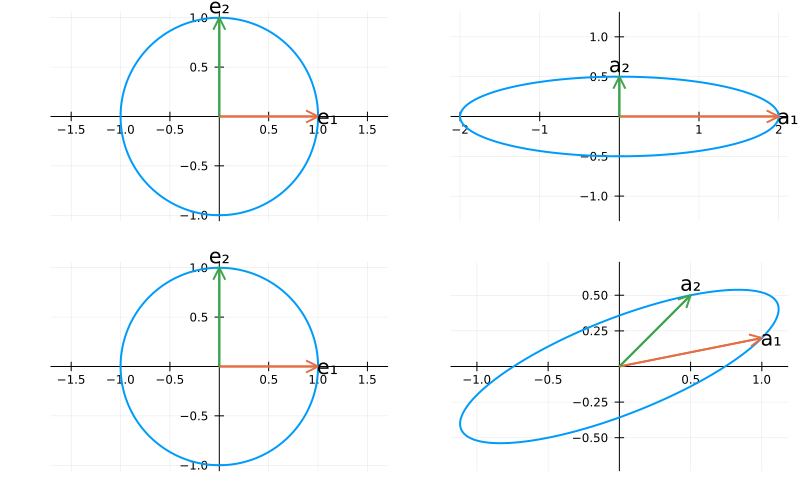

In [25]:
if STATIC_LECTURE
    plot1=plotAx(2.,0.0,0.,0.5)
    plot2=plotAx(1.,0.5,0.2,0.5)
    draw(plot(plot1,plot2,layout=(2,1)))
else
    a11=widget(-2.0:0.1:2.0, value=-2.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.0, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.0, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.5, label="a₂₂")
    iplot = map(plotAx,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

> The image of the unit sphere under any $m \times n$ matrix is a hyperellipse.

### Plotting preimages of the extrema is revealing

The extrema (_principle semiaxes_) of the tilted ellipse are orthogonal (true of any ellipse), but the _preimages_ of the extrema are also orthogonal.

In [26]:
function plotAx_svd(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,1],[0,0],arrow=1,text=["",("e₁", :left)])
    plot!(dplot, [0,0],[0,1],arrow=1,text=["",("e₂", :bottom)])
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("A⁻¹x₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("A⁻¹x₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,a1[1]],[0,a1[2]],arrow=1,text=["",("a₁", :left)])
    plot!(rplot, [0,a2[1]],[0,a2[2]],arrow=1,text=["",("a₂", :bottom)])
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("x₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("x₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

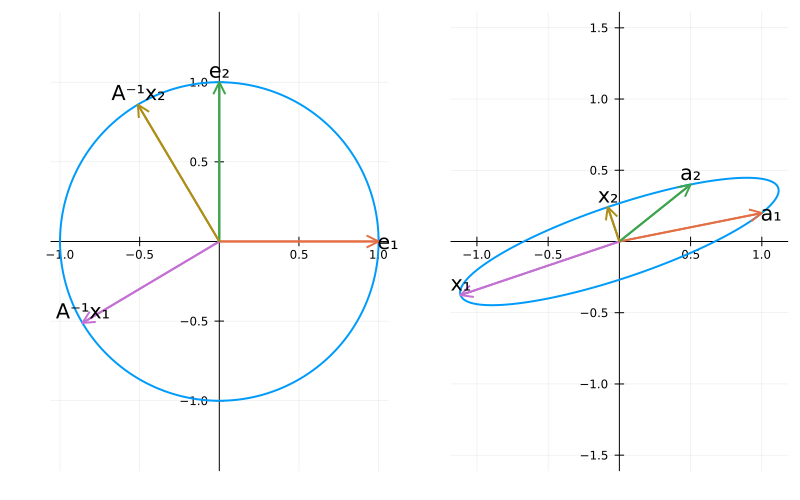

In [27]:
if STATIC_LECTURE
    plot2=plotAx_svd(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

### Relabel $A^{-1} x_i = v_i$

In [28]:
function plotAx_svd2(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("v₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("v₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("Av₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("Av₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

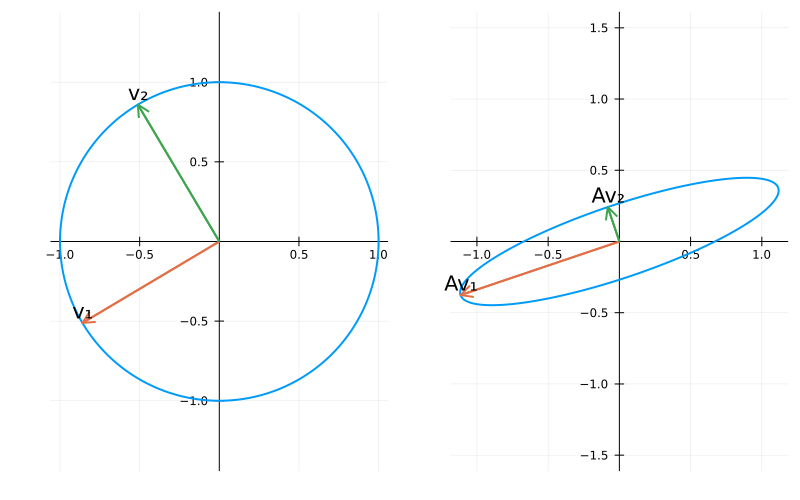

In [29]:
if STATIC_LECTURE
    plot2=plotAx_svd2(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd2,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

- Declare the ratio $\frac{\|Av_i\|_2}{\|v_i\|_2}$ to be the _singular value_ $\sigma_i$.
- Declare the normalized vector $\frac{1}{\|A v_i\|_2} A v_i$ to be $u_i$.

### $A: v_i \mapsto \sigma_i u_i$

In [30]:
function plotAx_svd3(a11,a12,a21,a22)
    θ = LinRange(0, 2π, 200)
    Ux = cos.(θ)
    Uy = sin.(θ)
    A = [[a11;a21] [a12;a22]]
    U,Σ,V = svd(A)
    a1 = A[:,1]
    a2 = A[:,2]
    dplot = plot(Ux, Uy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    plot!(dplot, [0,V[1,1]],[0,V[2,1]],arrow=1,text=["",("v₁", :bottom)])
    plot!(dplot, [0,V[1,2]],[0,V[2,2]],arrow=1,text=["",("v₂", :bottom)])
    Uxy = [Ux Uy]'
    AUxy = A * Uxy
    AUx = AUxy[1,:]
    AUy = AUxy[2,:]
    rplot = plot(AUx, AUy,
        aspect_ratio = :equal,
        framestyle = :origin,
    )
    AV = A * V
    plot!(rplot, [0,AV[1,1]],[0,AV[2,1]],arrow=1,text=["",("σ₁u₁", :bottom)])
    plot!(rplot, [0,AV[1,2]],[0,AV[2,2]],arrow=1,text=["",("σ₂u₂", :bottom)])
    return plot(dplot,rplot,layout=(1,2))
end;

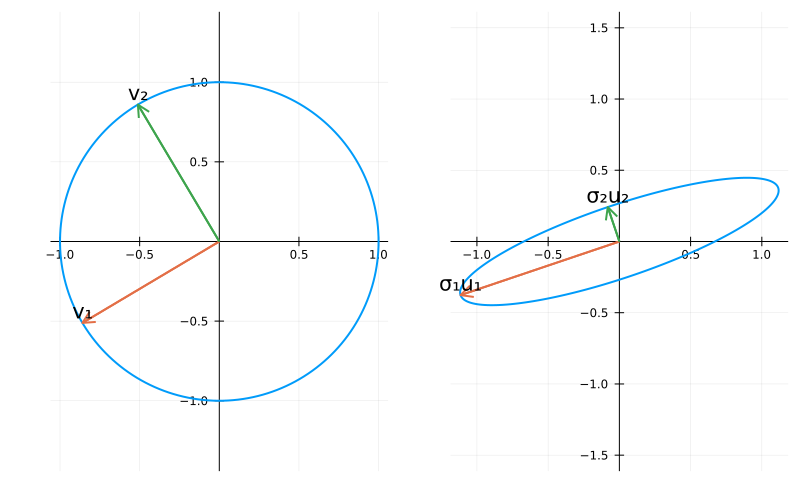

In [31]:
if STATIC_LECTURE
    plot2=plotAx_svd3(1.,0.5,0.2,0.4)
    draw(plot2)
else
    a11=widget(-2.0:0.1:2.0, value=1.0, label="a₁₁")
    a12=widget(-2.0:0.1:2.0, value=0.5, label="a₁₂")
    a21=widget(-2.0:0.1:2.0, value=0.2, label="a₂₁")
    a22=widget(-2.0:0.1:2.0, value=0.4, label="a₂₂")
    iplot = map(plotAx_svd3,a11,a12,a21,a22)
    vbox(hbox(a11,a12),hbox(a21,a22),iplot)
end

_This defines $A$, and we can do this for any $A$._

This is the geometric description of the _singular value decomposition_ of $A$

## SVD: Formal definition

### Reduced SVD

Assume $A \in \mathbb{C}^{m \times n}$. The orthonormal _left singular vectors_ $\{u_j\}$ are related to the orthonormal _right singular vectors_ $\{v_j\}$ by

$$
Av_j = \sigma_j u_j, \quad 1 \leq j \leq n.
$$

Write this out in matrix form:

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
v_1 & v_2 & \dots & v_n \\
& & & \\
& & & \\
\end{array}
\right]
=
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
& & & \\
u_1 & u_2 & \dots & u_n \\
& & & \\
& & & \\
& & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\end{bmatrix}.
$$

$$
A V = \hat{U}\hat{\Sigma}, \quad V \in \mathbb{C}^{n \times n}, \hat{U} \in \mathbb{C}^{m \times n}, \hat{\Sigma} \in \mathbb{R}^{n \times n} \text{(diagonal, nonnegative)}.
$$

$V$ has $n$ orthonormal columns in $\mathbb{C}^{n}$: it is unitary.  We can muliply both sides on the right by $V^* = V^{-1}$:

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
=
\left[
\begin{array}{c|c|c|c}
& & & \\
& & & \\
& & & \\
u_1 & u_2 & \dots & u_n \\
& & & \\
& & & \\
& & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\end{bmatrix}
\begin{bmatrix}
& & v_1^* & & \\ \hline
& & v_2^* & & \\ \hline
& & \vdots & & \\ \hline
& & v_n^* & & \\
\end{bmatrix}.
$$


$$
A = \hat{U}\hat{\Sigma}V^*, \quad V \in \mathbb{C}^{n \times n}, \hat{U} \in \mathbb{C}^{m \times n}, \hat{\Sigma} \in \mathbb{R}^{n \times n} \text{(diagonal, nonnegative)}.
$$

If $m > n$, this is the **reduced SVD**.

Note that though columns of $\hat{U}$ are orthogonal, $\hat{U}$ is not unitary if $m > n$ (because it is not square).

### Full SVD

If we complement $\hat{U}$ with additional orthonormal vectors to create an orthonormal basis of $\mathbb{C}^{m}$,

$$
\begin{bmatrix}
& & & & \\
& & & & \\
& & & & \\
& & A & & \\
& & & & \\
& & & & \\
& & & & \\
\end{bmatrix}
=
\left[
\begin{array}{ccc|c|c|c}
& & & & & \\
& & & & & \\
& & & & & \\
& \hat{U}&  & u_{n+1} & \dots & u_m \\
& & & & & \\
& & & & & \\
& & & & & \\
\end{array}
\right]
\begin{bmatrix}
\sigma_1 & & & \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\ \hline
& & & \\
& & & \\
& & &
\end{bmatrix}
\begin{bmatrix}
& & v_1^* & & \\ \hline
& & v_2^* & & \\ \hline
& & \vdots & & \\ \hline
& & v_n^* & & \\
\end{bmatrix},
$$
we get the _full SVD_ of $A$,

$$
A = U \Sigma V^*, \quad U \in \mathbb{C}^{m \times m}\text{ (unitary) },\quad V\in\mathbb{C}^{n \times n}\text{ (unitary) },\quad \Sigma \in \mathbb{R}^{m \times n}\text{ (positive, diagonal) }.
$$

### The extra vectors

The vectors $\{u_{n+1},\dots, u_m\}$ that complete $U$ can be _any_ orthonormal basis of
the orthogonal complement of $\hat{U}$.

### Example

1. First compute a reduced SVD (and confirm that $A = \hat{U} \hat{\Sigma} V^*$ up to rounding error).

In [32]:
m = 5; n = 3
A = randn(5,3)
U_hat, sigma_hat, V = svd(A, full=false)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
5×3 Matrix{Float64}:
  0.233055   0.250821   -0.450305
  0.805735   0.335442   -0.0382065
  0.386272  -0.0803425   0.0216164
 -0.317549   0.380734   -0.739435
 -0.215485   0.82046     0.498533
singular values:
3-element Vector{Float64}:
 4.1281516265970835
 1.678063157126389
 0.5520629960385777
Vt factor:
3×3 Matrix{Float64}:
  0.181598  -0.891505  -0.415019
 -0.86418   -0.346077   0.365273
  0.469271  -0.292319   0.833267

In [33]:
Sigma_hat = diagm(sigma_hat)
U_hat * Sigma_hat * V' - A

5×3 Matrix{Float64}:
 -1.66533e-16   3.33067e-16  -1.66533e-16
 -6.93889e-17   8.88178e-16  -4.44089e-16
  1.11022e-16   0.0          -1.11022e-16
 -3.33067e-16  -2.22045e-16  -1.66533e-16
 -6.66134e-16   6.93889e-16   2.22045e-16

2. Compute a full SVD (and show that the first 3 columns of $U$ are $\hat{U}$).

In [34]:
U, sigma, V = svd(A, full=true)

SVD{Float64, Float64, Matrix{Float64}}
U factor:
5×5 Matrix{Float64}:
  0.233055   0.250821   -0.450305   -0.785685  -0.250398
  0.805735   0.335442   -0.0382065   0.436528  -0.215068
  0.386272  -0.0803425   0.0216164  -0.208579   0.894632
 -0.317549   0.380734   -0.739435    0.363828   0.27399
 -0.215485   0.82046     0.498533   -0.127542   0.124939
singular values:
3-element Vector{Float64}:
 4.1281516265970835
 1.678063157126389
 0.5520629960385777
Vt factor:
3×3 Matrix{Float64}:
  0.181598  -0.891505  -0.415019
 -0.86418   -0.346077   0.365273
  0.469271  -0.292319   0.833267

In [35]:
U[:,1:3] - U_hat[:,1:3]

5×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [36]:
sigma - sigma_hat

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [37]:
Sigma = [diagm(sigma);zeros(2,3)] 
U * Sigma * V' - A

5×3 Matrix{Float64}:
 -1.11022e-16   2.22045e-16  -1.11022e-16
 -9.71445e-17   8.88178e-16  -4.44089e-16
  5.55112e-17   0.0          -1.11022e-16
 -3.33067e-16  -2.22045e-16  -1.66533e-16
 -6.66134e-16   7.49401e-16   2.22045e-16

3. Rotate the extra vectors to make $U_{\text{new}}$ and show that the SVD is unaffected.

In [38]:
U_extra = U[:,4:end]

θ = rand()
R = [[cos(θ);sin(θ)] [-sin(θ);cos(θ)]]
U_extra_new = U_extra * R
U_new = [U_hat U_extra_new]
U - U_new

5×5 Matrix{Float64}:
 0.0  0.0  0.0   0.0380962  -0.213186
 0.0  0.0  0.0   0.071046    0.106232
 0.0  0.0  0.0  -0.240108   -0.0234516
 0.0  0.0  0.0  -0.058786    0.10417
 0.0  0.0  0.0  -0.0369259  -0.0288966

In [39]:
U_new * Sigma * V' - A

5×3 Matrix{Float64}:
 -1.11022e-16   2.22045e-16  -1.11022e-16
 -9.71445e-17   8.88178e-16  -4.44089e-16
  5.55112e-17   0.0          -1.11022e-16
 -3.33067e-16  -2.22045e-16  -1.66533e-16
 -6.66134e-16   7.49401e-16   2.22045e-16

### Formal definition

A _singular value decomposition_ (SVD) of $A \in \mathbb{C}^{m \times n}$ (do not require $m \geq n$) is a factorization

$$
A = U \Sigma V^*,\quad U \in \mathbb{C}^{m \times m}\text{ (unitary) },\quad V\in\mathbb{C}^{n \times n}\text{ (unitary) },\quad \Sigma \in \mathbb{R}^{m \times n}\text{ (positive, diagonal) },
$$

where we further require $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_p \geq 0$ ($p = \min\{m,n\}$).

### Existence and Uniqueness

**Theorem:** (Slightly modified from T&B Theorem 4.4)

Every matrix $A$ has a singular value decomposition.  If $U \Sigma V^*$ and $\tilde{U} \tilde{\Sigma} \tilde{V}^*$ are
two SVDs of $A$, then $\Sigma = \tilde{\Sigma}.$ If $i \neq j$, then either

1. $u_i^* \tilde u_j = 0$, or

2. $\sigma_i = \sigma_j$ (taking $\sigma_i = 0$ if $i > \min\{m,n\}$).

The same is true of the vectors in $V$ and $\tilde V$.

### T&B Exercise 4.4

Two matrices $A, B \in \mathbb{C}^{m \times m}$ are _unitarily equivalent_ if $A = Q B Q^*$ for some unitary
$Q \in \mathbb{C}^{m \times m}$.  Is it true or false that $A$ and $B$ are unitarily equivalent if and only if they have the same singular values?